
# Landlab Landslide Probability Model with Saturation 

<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:200px;padding:20px">   


<br />
This Jupyter Notebook runs the Landlab LandslideProbability component on a synthetic 
Landlab grid using four depth to water table options to replace recharge options described in the paper: <br />
#### Strauch et al. 2018. A hydro-climatological approach to predicting regional landslide probability using Landlab. Earth Surface Dynamics, 6, 1-26. <br /> 
This notebook performs the following functions:<br >
* Import libraries and set HydroShare variables<br />
* Create a grid and data fields used to calculate landslide probability<br />
* Specify Depth to Water Table Distributions to compare four options<br /> 
* Run LandslideProbability function from Landlab landslide component<br /> 
* Compare the sensitivity based on four Depth to Water Table options<br /> 



## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading, and creation.  Additional libraries support the functions of Landlab. 

In [8]:
#import Python utilities for calculating and plotting
import six
import os
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

print('Ignore deprecation warnings')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

#import utilities for importing and exporting to HydroShare
from utilities import hydroshare
# set variables for interacting with HydroShare from this notebook
hs=hydroshare.hydroshare()
# Create object to map the home directory
hs=hydroshare.hydroshare()
homedir = os.getcwd()
print('Data will be loaded from and saved to:'+homedir)
os.chdir('/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents')
print(homedir)

# Import Landlab libraries
import landslide_probability
from landslide_probability_20191122 import LandslideProbability
from landlab import RasterModelGrid
from landlab import imshow_grid_at_node


Ignore deprecation warnings
Successfully established a connection with HydroShare
Successfully established a connection with HydroShare
Data will be loaded from and saved to:/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents
/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to see a File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## Create a grid and data fields used to calculate landslide probability

This example uses a synthetic model domain. As a first example, make a synthetic grid with 5 rows and 4 columns space 0.2 units apart.   <br /> 
##### Synthetic Grid Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the rows, columns, and spacing of your choice.  

In [9]:
grid = RasterModelGrid((5, 4), spacing=(0.2, 0.2))

Confirm the size of the grid

In [10]:
grid.number_of_nodes

20

To see what the grid id of our nodes are, execute the command below.  However, note that this command gives you the rows of the grid, but these are technically up-side-down from how the RasterModelGrid nodes are numbered (e.g,. node id 0 is at the bottom left corner of the grid). 

In [11]:
grid.nodes

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19]])

We can also see how many core nodes we have (i.e., the nodes that calculations are performed on) in the center of the grid...not the edges, which are 'closed nodes'. Compare this array to the full grid above.  Asign these to the variable 'core_nodes' so we can use these later.

Now we will create the required fields for the landslide component and add data as fields to the grid.  Thus, the data arrays will need to be as the length of the number of nodes.<br /> 
##### Data Fields Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the data inputs of your choice.  

In [12]:
gridnodes = grid.number_of_nodes
grid_size = grid.number_of_nodes

grid['node']['soil__density']= \
         2000. * np.ones(gridnodes)

grid['node']['soil__internal_friction_angle']= \
         np.sort(np.random.randint(26, 37, gridnodes))

grid['node']['soil__mode_total_cohesion']= \
         np.sort(np.random.randint(30, 900, gridnodes))
    
scatter_dat = np.random.randint(1, 10, gridnodes)    
grid['node']['soil__maximum_total_cohesion']= \
         grid.at_node['soil__mode_total_cohesion'] + scatter_dat

grid['node']['soil__minimum_total_cohesion']= \
         grid.at_node['soil__mode_total_cohesion'] - scatter_dat

grid['node']['soil__thickness']= \
         np.sort(np.random.randint(1, 10, gridnodes))

grid['node']['soil__transmissivity']= \
         np.sort(np.random.randint(5, 20, gridnodes),-1)
        
grid['node']['topographic__slope'] = np.random.rand(gridnodes)

grid['node']['topographic__specific_contributing_area']= \
         np.sort(np.random.randint(30, 900, gridnodes))

Let's see what one of these fields (slope) looks like on the grid.

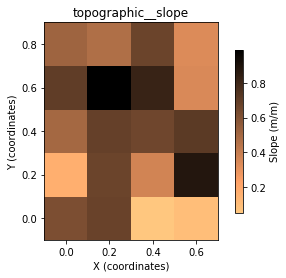

In [15]:
plt.figure('Slope')
imshow_grid_at_node(grid,'topographic__slope', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')
plt.savefig('Slope.png')

In [17]:
grid['node']['soil__thickness']

array([1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 6, 7, 7, 8, 8, 8, 8, 9, 9, 9])

In [16]:
np.mean(grid['node']['soil__thickness'])

5.3499999999999996

## Relative wetness calculated from Depth to Water Table

In [23]:
n=50
Demin_value = 2 
Demax_value = 5
distribution1 = 'uniform'
depth_dist = np.random.uniform(Demin_value, Demax_value,size=n)
print('Depth to water table distribution')
print(depth_dist)

mean_depth=np.mean(depth_dist)
grid['node']['soil__mean_watertable_depth']=mean_depth* np.ones(gridnodes)

print('Mean depth to water table from uniform distribution')
print(mean_depth)
print('Mean Depth to water table - uniform fpr all nodes')
print(grid['node']['soil__mean_watertable_depth'])

Depth to water table distribution
[ 2.4426411   2.11309587  4.47938199  3.57753432  4.94374672  3.68491481
  2.67251199  4.18433648  3.43773181  2.60424211  3.60368008  4.54069203
  4.93824221  3.2884353   3.37682835  4.76004143  4.35500286  2.7962739
  3.95164906  2.5881454   4.02274071  4.33898487  4.9486785   3.11864476
  2.82649524  4.21778813  2.39482184  3.87232283  4.1096377   4.76753506
  2.86321008  3.73822177  3.74345486  3.43800463  2.80141909  3.58291524
  3.37670331  4.78840277  2.46699351  2.29535942  3.61300738  4.10818632
  4.70471041  2.14728958  4.65768334  4.46222733  2.51312232  2.67758432
  2.12782961  2.50779575]
Mean depth to water table from uniform distribution
3.55141797025
Mean Depth to water table - uniform fpr all nodes
[ 3.55141797  3.55141797  3.55141797  3.55141797  3.55141797  3.55141797
  3.55141797  3.55141797  3.55141797  3.55141797  3.55141797  3.55141797
  3.55141797  3.55141797  3.55141797  3.55141797  3.55141797  3.55141797
  3.55141797  3.551417

In [28]:
hw=grid['node']['soil__thickness']-grid['node']['soil__mean_watertable_depth']
print('Height of water (hw)')
print(hw)

Height of water (hw)
[-2.55141797 -1.55141797 -1.55141797 -1.55141797 -1.55141797 -0.55141797
 -0.55141797  0.44858203  0.44858203  1.44858203  2.44858203  3.44858203
  3.44858203  4.44858203  4.44858203  4.44858203  4.44858203  5.44858203
  5.44858203  5.44858203]


In [29]:
hw[np.where(hw<0)] = grid['node']['soil__thickness'][np.where(hw<0)]
print('Height of water (hw)corrected for saturated conditions limited to soil thickness')
print(hw)

Height of water (hw)corrected for saturated conditions limited to soil thickness
[ 1.          2.          2.          2.          2.          3.          3.
  0.44858203  0.44858203  1.44858203  2.44858203  3.44858203  3.44858203
  4.44858203  4.44858203  4.44858203  4.44858203  5.44858203  5.44858203
  5.44858203]


In [32]:
grid['node']['relative_wetness_d']= hw/grid['node']['soil__thickness']

grid['node']['relative_wetness_d']

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  0.11214551,  0.11214551,  0.28971641,
        0.408097  ,  0.49265458,  0.49265458,  0.55607275,  0.55607275,
        0.55607275,  0.55607275,  0.605398  ,  0.605398  ,  0.605398  ])

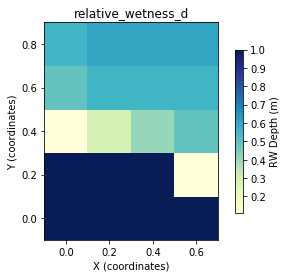

In [33]:
plt.figure('Water Table Depth')
imshow_grid_at_node(grid,'relative_wetness_d', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='RW Depth', var_units='m')
plt.savefig('rw.png')

## Relative wetness calculated from Recharge

In [61]:
n=50
Remin_value = 5
Remax_value = 20
distribution1 = 'uniform'
recharge_dist = np.random.uniform(Remin_value, Remax_value,size=n)
print('Recharge distribution')
print(recharge_dist)# values in mm
mean_recharge=np.mean(recharge_dist)/1000#convert mm to meters
print('Mean recharge from uniform distribution')
print(mean_recharge)
grid['node']['soil__mean_recharge']=mean_recharge* np.ones(gridnodes)
print('Mean Recharge - uniform fpr all nodes')
print(grid['node']['soil__mean_recharge'])

Recharge distribution
[  9.63656503   5.98176602  14.36640941   8.96972732  19.55157954
   7.00991668  11.32150187   9.97064374   5.73470147   5.8783746
  11.07117464  15.55608532  16.91949104  11.94587106  10.00077517
  15.12148177   5.8708695   16.26595197  12.67803017  13.32867345
  15.21060813   7.34274832   5.26690779   8.17426638  13.23131135
   8.69852555  13.07075983  16.24922362   7.10983351  19.43591756
  15.54508297  15.67230628  13.18267179   6.20028618  17.69638214
   7.38547611  15.56701209  10.75600973  10.23862252   7.397258
  12.54941467  12.94095034  16.46878681  15.95951472  16.71300959
  10.30568855   9.8819176   12.73751484  14.34818469  16.32358266]
Mean recharge from uniform distribution
0.011976787282
Mean Recharge - uniform fpr all nodes
[ 0.01197679  0.01197679  0.01197679  0.01197679  0.01197679  0.01197679
  0.01197679  0.01197679  0.01197679  0.01197679  0.01197679  0.01197679
  0.01197679  0.01197679  0.01197679  0.01197679  0.01197679  0.01197679
  0.0119

In [62]:
water_input=grid['node']['soil__mean_recharge']*grid['node']['topographic__specific_contributing_area']
print('Water input to each cell')
print(water_input)

Water input to each cell
[  0.73058402   2.01210026   2.10791456   2.55105569   3.07803433
   5.54525251   5.78478826   5.97641685   5.98839364   6.00037043
   6.33572047   7.00642056   7.04235092   8.08433142   8.50351897
   9.44968517   9.6053834    9.96468702  10.22817634  10.32399064]


In [63]:
capacity=grid['node']['soil__transmissivity']*np.sin(np.arctan(grid['node']['topographic__slope']))
print('Water holding capacity of each cell')
print(capacity)


Water holding capacity of each cell
[  3.16846323   3.36244697   0.3553152    0.85728622   1.47776255
   5.02026517   3.1092834    5.97073444   5.39537623   7.37848009
   7.164411     8.17414775   8.64974911  10.57035709   9.55289082
   4.86130285   6.91203292   7.6619334   10.01471944   5.7455086 ]


In [64]:
grid['node']['relative_wetness_r']=water_input/capacity
grid['node']['relative_wetness_r']

array([ 0.23057993,  0.59840357,  5.93252012,  2.97573392,  2.08290184,
        1.10457363,  1.86048923,  1.00095171,  1.10991215,  0.81322581,
        0.88433236,  0.85714386,  0.81416823,  0.76481157,  0.89015138,
        1.94385856,  1.38966112,  1.30054472,  1.02131432,  1.7968802 ])

In [65]:
np.place(grid['node']['relative_wetness_r'], grid['node']['relative_wetness_r'] > 1, 1.0)

grid['node']['relative_wetness_r']

array([ 0.23057993,  0.59840357,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.81322581,
        0.88433236,  0.85714386,  0.81416823,  0.76481157,  0.89015138,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ])

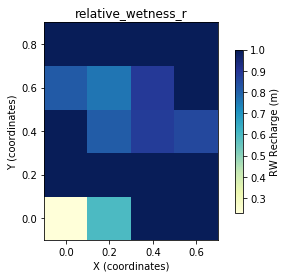

In [66]:
plt.figure('Recharge')
imshow_grid_at_node(grid,'relative_wetness_r', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='RW Recharge', var_units='m')
plt.savefig('rw.png')

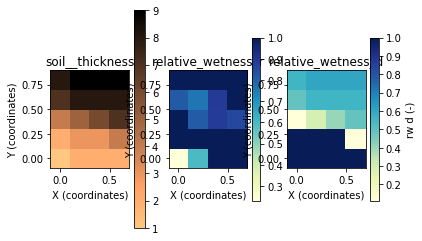

In [107]:
fig = plt.figure('Water Table Depth Calculations')
#xticks = np.arange(-0.1, 1.6, 0.8)


ax1 = fig.add_subplot(131)
ax2.figsize=(5,4)
#ax1.set_visible(False)
#ax1.set_xticks(xticks)
imshow_grid_at_node(grid, 'soil__thickness', plot_name='soil (m)',
                    allow_colorbar=True, cmap='copper_r',
                    grid_units=('coordinates', 'coordinates'))

ax2 = fig.add_subplot(132)
ax2.figsize=(5,4)
#ax2.set_xticks(xticks)
imshow_grid_at_node(grid, 'relative_wetness_r', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='mean_rw', var_units='m')

ax3 = fig.add_subplot(133)
ax3.figsize=(5,4)
#ax3.set_xticks(xticks)
imshow_grid_at_node(grid, 'relative_wetness_d', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='rw d', var_units='-')



### Results: relative wetness is a function of soil thickness given uniform depth to groundwater (assume steady state to depth to groundwater (dtw) is equivelent to depth of water recharged )

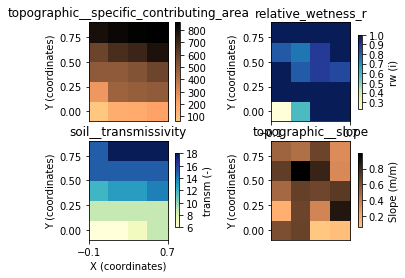

In [108]:
fig = plt.figure('Water Table Depth Calculations')
xticks = np.arange(-0.1, 1.6, 0.8)


ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid_at_node(grid, 'topographic__specific_contributing_area', plot_name='area',
                    allow_colorbar=True, cmap='copper_r',
                    grid_units=('coordinates', 'coordinates'))

ax2 = fig.add_subplot(222)
ax2.set_xticks(xticks)
imshow_grid_at_node(grid, 'relative_wetness_r', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='rw', var_units='i')

ax3 = fig.add_subplot(223)
ax3.set_xticks(xticks)
imshow_grid_at_node(grid, 'soil__transmissivity', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='transm', var_units='-')

ax4 = fig.add_subplot(224)
ax4.xaxis.set_visible(False)
imshow_grid_at_node(grid,'topographic__slope', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')



### Results: relative wetness is a function of contributing area given uniform recharge (assume steady state depth of water is equivalent to depth to groundwater (dtw) )